Import dependencies and configure settings.

In [1]:
import os
import csv
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.api as sm

from pylab import rcParams
from __future__ import division

%matplotlib inline
np.set_printoptions(precision=10)

Load MSFT order message data with 10 price levels into dict.

In [2]:
dat = 'MSFT_2012-06-21_34200000_57600000_message_10'
temp = ([],[],[],[],[],[])
with open('../data/'+dat+'.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temp[0].append(float(row[0]))
        temp[1].append(int(row[1]))
        temp[2].append(int(row[2]))
        temp[3].append(int(row[3]))
        temp[4].append(int(row[4]))
        temp[5].append(int(row[5]))

orders = {'Time':None, 'Type':None, 'Order ID':None,
        'Volume':None, 'Price':None, 'Direction':None}
orders['Time'] = np.asarray(temp[0])
orders['Type'] = np.asarray(temp[1])
orders['Order ID'] = np.asarray(temp[2])
orders['Volume'] = np.asarray(temp[3])
orders['Price'] = np.asarray(temp[4])
orders['Direction'] = np.asarray(temp[5])
del temp

Looking at the distribution of the order types in the order flow during the 390 minutes of data available, we have:

In [3]:
ttemp = len(orders['Type'])
print("{0} order messages total:".format(len(orders['Type'])))
temp = len(orders['Type'][orders['Type']==1])
print("- {0} LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==2])
print("- {0} partial LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==3])
print("- {0} LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==4])
print("- {0} visible LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==5])
print("- {0} hidden LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==7])
print("- {0} trading halts ({1:.2f}%)".format(temp,100*temp/ttemp))
del ttemp
del temp

668765 order messages total:
- 329566 LO submissions (49.28%)
- 5602 partial LO cancellations (0.84%)
- 300183 LO cancellations (44.89%)
- 29798 visible LO execution (4.46%)
- 3616 hidden LO execution (0.54%)
- 0 trading halts (0.00%)


Analysing the intervals of all events in the order flow. Defining time as an integer representing 10s of picoseconds.

In [4]:
O_t = orders['Time']

Events with the same timestamp has to be injected with picoseconds for randomised precision.

In [5]:
mask = [False]
for i in xrange(len(O_t)-1):
    if O_t[i] == O_t[i+1]:
        mask.append(True)
    else:
        mask.append(False)

mask = np.asarray(mask)
mask = np.diff(np.array([False] + mask + [False], dtype=np.int))
mask = zip(np.where(mask==1)[0], np.where(mask==-1)[0])

for m in mask:
    inject = np.arange(m[1]+1-m[0])/1e11
    for i,j in zip(xrange(m[0],m[1]+1),xrange(len(inject))):
        O_t[i] = O_t[i] + inject[j]
        
del mask

Plotting the intervals between events. We're looking for long intervals that are followed by periods of short intervals for indication of clustering.

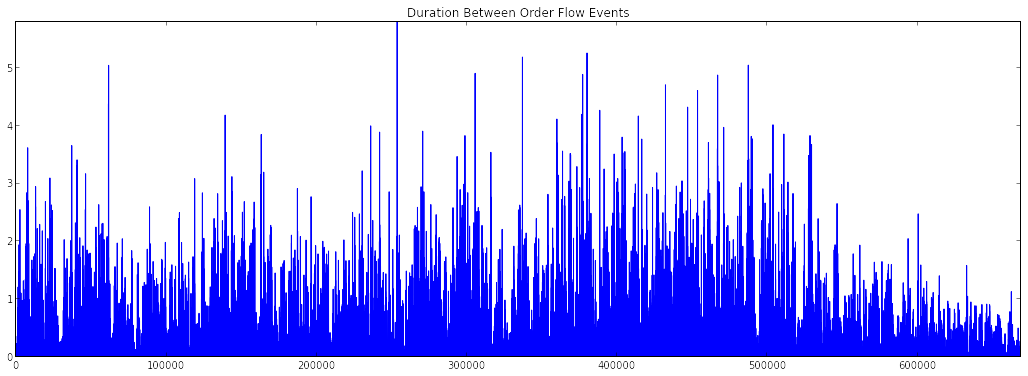

In [6]:
O_int = np.diff(O_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(O_int)), O_int)
plt.title('Duration Between Order Flow Events')
plt.axis([0, len(O_int), min(O_int), max(O_int)])
plt.show()

Plotting the empirical cumulative density function of order flow event intervals.

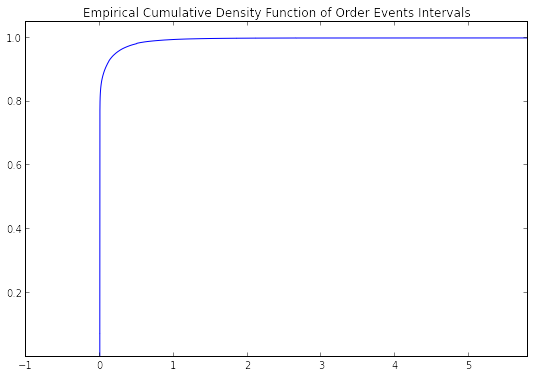

In [7]:
ecdf = sm.distributions.ECDF(O_int)
x = np.sort(O_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

Now, we plot the quantiles of the order flow events intervals against the quantiles of an exponential distribution. If the limit order submissions are declustered, we expect the events to be exponentially distributed.

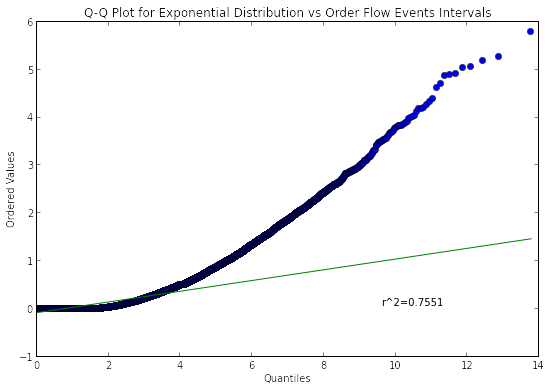

In [8]:
rcParams['figure.figsize'] = 9, 6
stats.probplot(O_int, dist="expon", plot=plt)
plt.title("Q-Q Plot for Exponential Distribution vs Order Flow Events Intervals")
plt.show()

Now, we focus on only limit order (LO) submissions.

In [9]:
LO_t = O_t[orders['Type']==1]

Plotting the intervals between limit order submissions. We're looking for long intervals that are followed by periods of short intervals for indication of clustering.

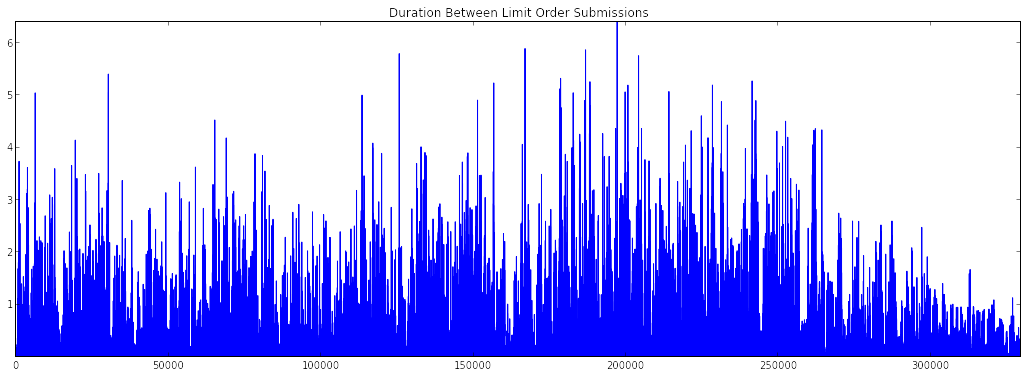

In [10]:
LO_int = np.diff(LO_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(LO_int)), LO_int)
plt.title('Duration Between Limit Order Submissions')
plt.axis([0, len(LO_int), min(LO_int), max(LO_int)])
plt.show()

Plotting the empirical cumulative density function of the LO submission intervals.

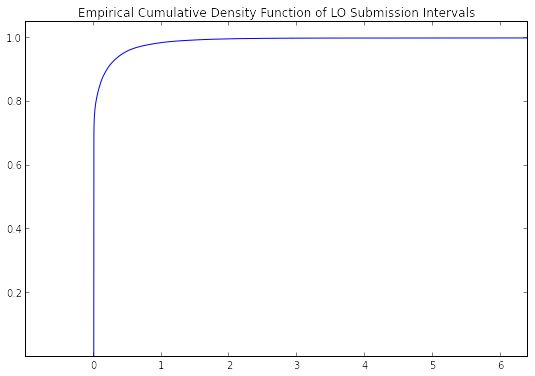

In [11]:
ecdf = sm.distributions.ECDF(LO_int)
x = np.sort(LO_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of LO Submission Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

Now, we plot the quantiles of the limit order submission intervals against the quantiles of an exponential distribution. If the limit order submissions are declustered, we expect the intervals between the limit order submissions to be exponentially distributed.

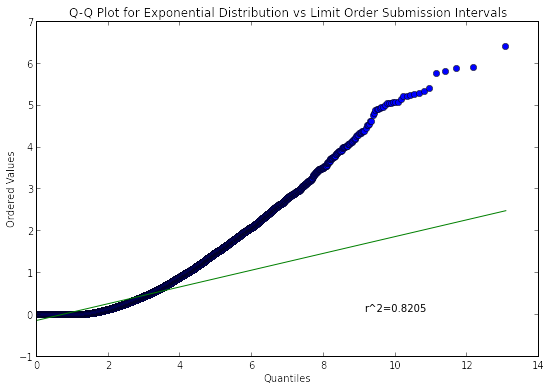

In [12]:
rcParams['figure.figsize'] = 9, 6
stats.probplot(LO_int, dist="expon", plot=plt)
plt.title("Q-Q Plot for Exponential Distribution vs Limit Order Submission Intervals")
plt.show()

Next, we look at the (MO) market orders. We define market orders as the events which results in the execution of visible limit orders. For now, execution of hidden limit orders are disregarded.

In [13]:
MO_t = O_t[(orders['Type']==4)]

Plotting the intervals between market order events. We're looking for long intervals that are followed by periods of short intervals for indication of clustering.

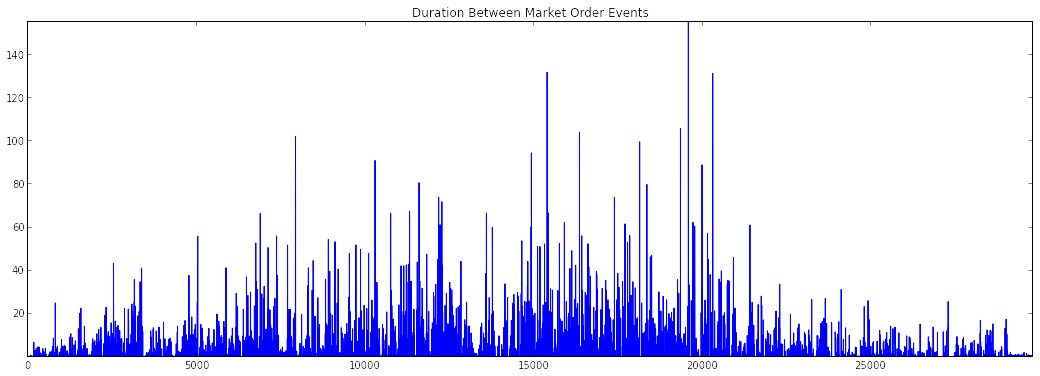

In [14]:
MO_int = np.diff(MO_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(MO_int)), MO_int)
plt.title('Duration Between Market Order Events')
plt.axis([0, len(MO_int), min(MO_int), max(MO_int)])
plt.show()

Plotting the empirical cumulative density function of the MO event intervals.

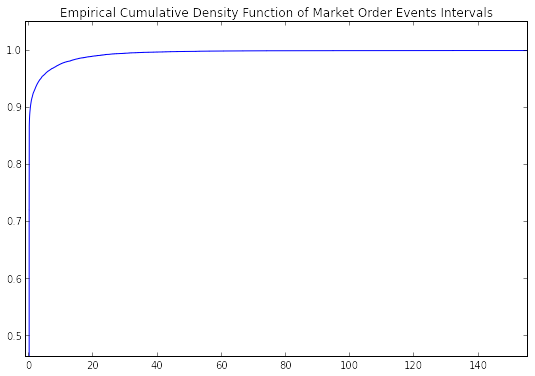

In [15]:
ecdf = sm.distributions.ECDF(MO_int)
x = np.sort(MO_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of Market Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

Now, we plot the quantiles of the MO events intervals against the quantiles of an exponential distribution. If the events are declustered, we expect the intervals to be exponentially distributed.

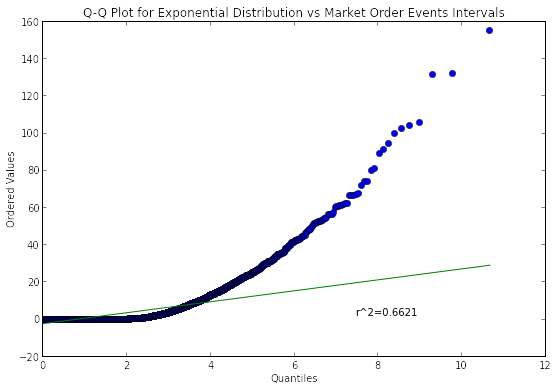

In [16]:
rcParams['figure.figsize'] = 9, 6
stats.probplot(MO_int, dist="expon", plot=plt)
plt.title("Q-Q Plot for Exponential Distribution vs Market Order Events Intervals")
plt.show()

Then, we look at the (CO) cancellation orders. Partial cancellations are disregarded.

In [17]:
CO_t = O_t[orders['Type']==3]

Plotting the intervals between cancellation order events. We're looking for long intervals that are followed by periods of short intervals for indication of clustering.

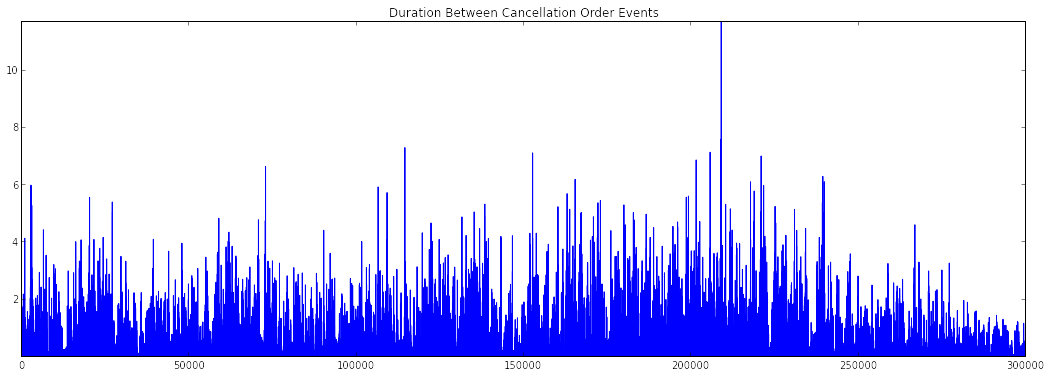

In [18]:
CO_int = np.diff(CO_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(CO_int)), CO_int)
plt.title('Duration Between Cancellation Order Events')
plt.axis([0, len(CO_int), min(CO_int), max(CO_int)])
plt.show()

Plotting the empirical cumulative density function of the CO event intervals.

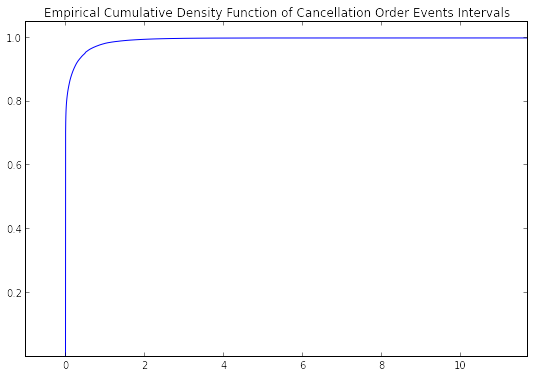

In [19]:
ecdf = sm.distributions.ECDF(CO_int)
x = np.sort(CO_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of Cancellation Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

Now, we plot the quantiles of the CO events intervals against the quantiles of an exponential distribution. If the events are declustered, we expect the intervals to be exponentially distributed.

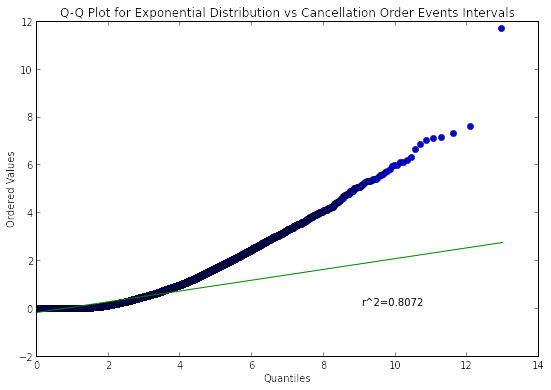

In [20]:
rcParams['figure.figsize'] = 9, 6
stats.probplot(CO_int, dist="expon", plot=plt)
plt.title("Q-Q Plot for Exponential Distribution vs Cancellation Order Events Intervals")
plt.show()

Next, analysing the intervals between a market order event followed by a limit order submission.

In [21]:
ML_int = []
for i in np.where((orders['Type']==4)[:-1] & (orders['Type']==1)[1:])[0]:
    ML_int.append(O_t[i+1]-O_t[i])
ML_int = np.asarray(ML_int)

print "There are {} events of a LO submission following a MO event.".format(len(ML_int))

There are 3072 events of a LO submission following a MO event.


Plotting the intervals.

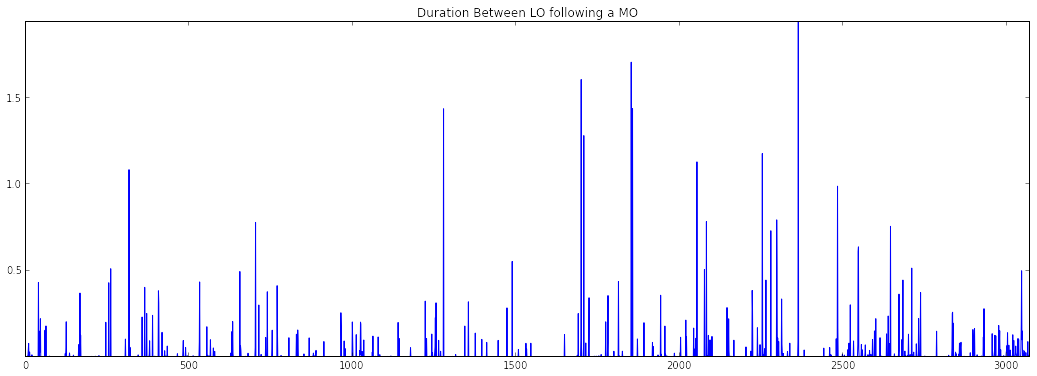

In [22]:
rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(ML_int)), ML_int)
plt.title('Duration Between LO following a MO')
plt.axis([0, len(ML_int), min(ML_int), max(ML_int)])
plt.show()

Plotting the empirical cumulative density function of the intervals and comparing it to the ECDF of all orders. Comparing the ECDF, the intervals between the arrival of limit orders right after a market order event are slightly smaller than that of the order flow in general.

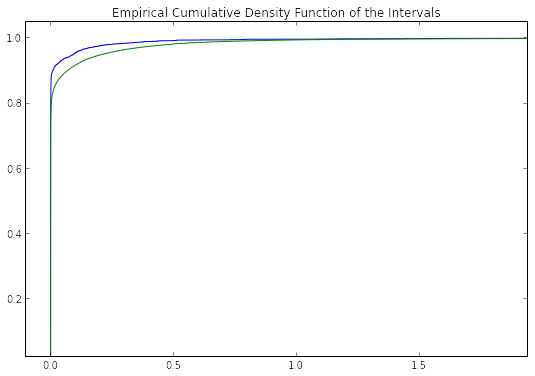

In [23]:
ecdf = sm.distributions.ECDF(ML_int)
x = np.sort(ML_int)
y = ecdf(x)

ecdfo = sm.distributions.ECDF(O_int)
xo = np.sort(O_int)
yo = ecdfo(xo)

rcParams['figure.figsize'] = 9, 6
plt.step(x,y)
plt.step(xo,yo)
plt.title('Empirical Cumulative Density Function of the Intervals')
plt.axis([min(x)-0.1, max(x), min(y), max(y)+0.05])
plt.legend
plt.show()

del ecdf, ecdfo
del x, xo
del y, yo

Plotting the quantiles of the intervals against the quantiles of an exponential distribution.

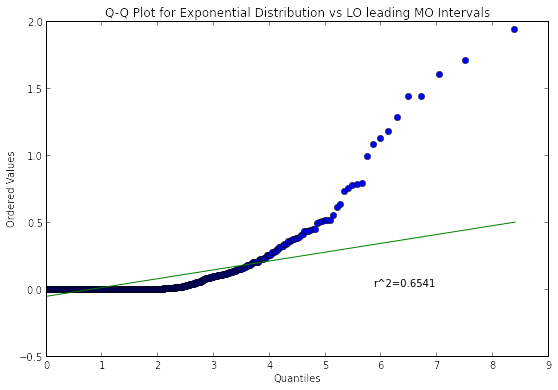

In [24]:
rcParams['figure.figsize'] = 9, 6
stats.probplot(ML_int, dist="expon", plot=plt)
plt.title("Q-Q Plot for Exponential Distribution vs LO leading MO Intervals")
plt.show()